In [1]:
# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime
import hashlib

# Scientific computing
import numpy as np
import scipy as sp

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import (
    DataLoader, Dataset, TensorDataset,
    random_split, ConcatDataset
)
from torchvision import transforms

# Neural operator specific
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer, LpLoss, H1Loss

# Data processing and visualization
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Progress tracking
from tqdm import tqdm

In [2]:
# Force garbage collection to release file handles
import gc
gc.collect()

291

## Load and visualize data

In [8]:
current_dir = os.getcwd()
reduced_dataset_path_reserved = os.path.join(current_dir, 'data', 'reduced', 'reserved', 'reduced_dataset_reserved.pt')
# Load all 16 datasets
dataset_reserved = torch.load(reduced_dataset_path_reserved)

# Print info about each dataset
print("Dataset Reserved:")
print(f"Type: {type(dataset_reserved)}")
print(f"Length: {len(dataset_reserved)}")
if hasattr(dataset_reserved, 'tensors'):
    for i, tensor in enumerate(dataset_reserved.tensors):
        print(f"Tensor {i}: shape {tensor.shape}, dtype {tensor.dtype}")
print("\n")

dataset = dataset_reserved

C:\Users\hz283\AppData\Local\Temp\ipykernel_65064\2385426739.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_reserved = torch.load(reduced_dataset_path_reserved)

Dataset Reserved:
Type: <class 'torch.utils.data.dataset.TensorDataset'>
Length: 145800
Tensor 0: shape torch.Size([145800, 3, 32, 32]), dtype torch.float32
Tensor 1: shape torch.Size([145800, 4, 32, 32]), dtype torch.float32




In [9]:
# Combine all 8 datasets into one using ConcatDataset
# dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3, dataset4, 
#                                         dataset5, dataset6, dataset7, dataset8,
#                                         dataset9, dataset10, dataset11, dataset12,
#                                         dataset13, dataset14, dataset15, dataset16])

# # Print basic dataset info
# print(f"Dataset type: {type(dataset)}")
# print(f"Number of samples: {len(dataset)}")

# # Get info about first sample to understand structure
# first_sample = dataset[0]
# if isinstance(first_sample, tuple):
#     print("\nFirst sample structure:")
#     for i, item in enumerate(first_sample):
#         if torch.is_tensor(item):
#             print(f"Item {i}: shape {item.shape}, dtype {item.dtype}")
#         else:
#             print(f"Item {i}: type {type(item)}")


In [10]:
def visualize_sample(input_tensor, output_tensor):
    """
    Visualize input and output tensors from a single sample.
    
    Args:
        input_tensor: Tensor of shape (3, H, W) containing input components
        output_tensor: Tensor of shape (4, H, W) containing output components
    """
    # Create figure for input components
    fig1 = plt.figure(figsize=(12, 4))

    # Plot input tensor components (1x3 subplot)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        im = plt.imshow(input_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Input Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for output components 
    fig2 = plt.figure(figsize=(16, 4))

    # Plot output tensor components (1x4 subplot)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        im = plt.imshow(output_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Output Component {i+1}')

    plt.tight_layout()
    plt.show()

Visualizing random sample 113434


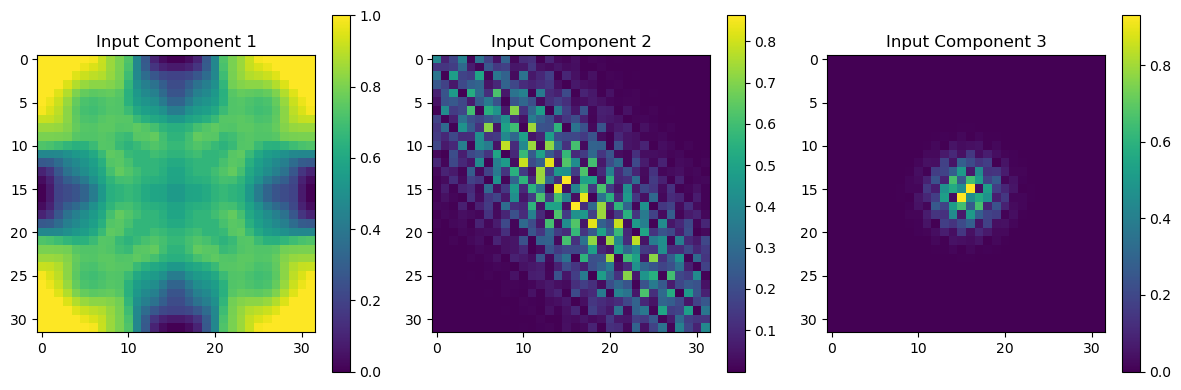

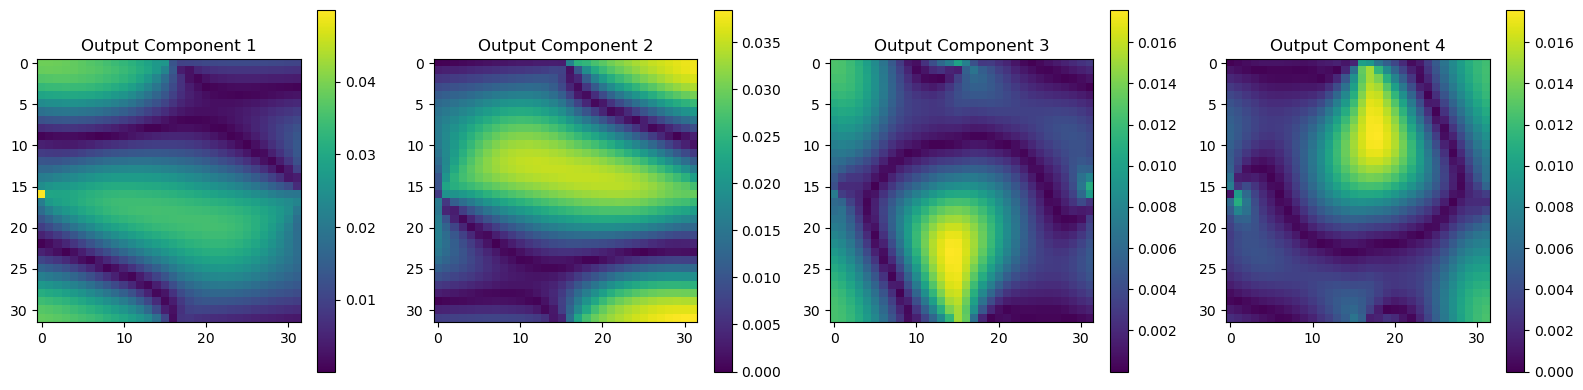

In [11]:
# Get a random sample from the dataset
random_idx = np.random.randint(0, len(dataset))
sample = dataset[random_idx]

# Extract input and output tensors from the sample
input_tensor = sample[0]  # First element is input
output_tensor = sample[1] # Second element is output

print(f"Visualizing random sample {random_idx}")
visualize_sample(input_tensor, output_tensor)

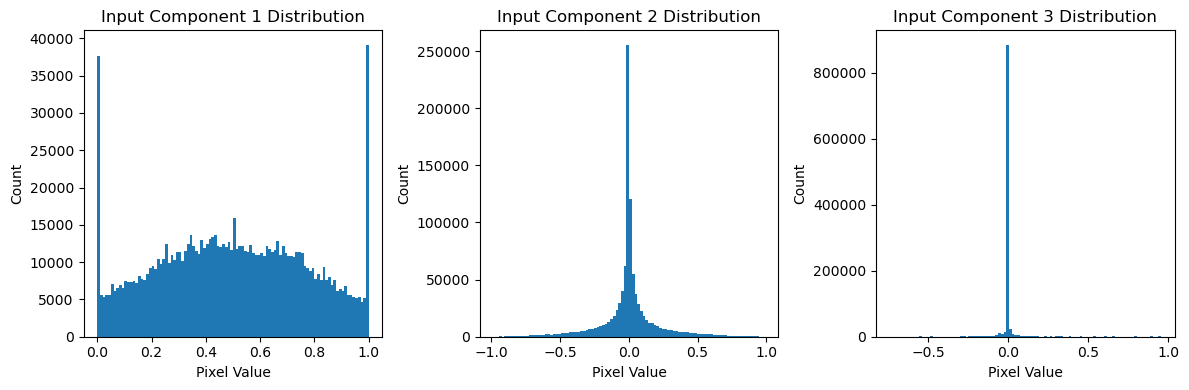

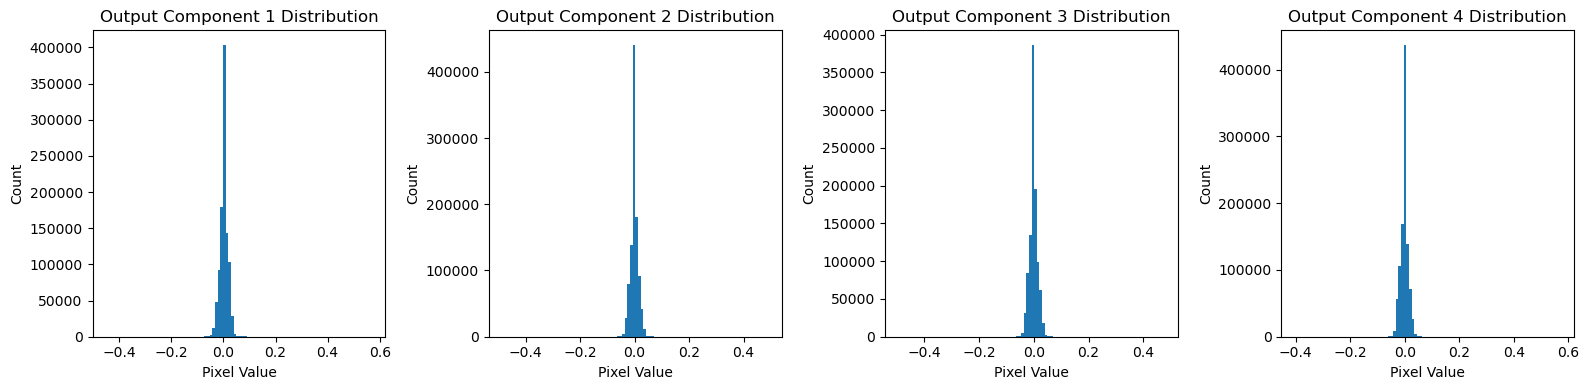

In [13]:
# Create arrays to store all pixel values across dataset
input_pixels = [[] for _ in range(3)]  # 3 input components
output_pixels = [[] for _ in range(4)] # 4 output components

# Sample a subset of the dataset for efficiency
num_samples = min(1000, len(dataset))
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)

# Collect pixel values
for idx in sample_indices:
    sample = dataset[idx]
    input_tensor = sample[0]
    output_tensor = sample[1]
        # Gather input pixels
    for i in range(3):
        input_pixels[i].extend(input_tensor[i].numpy().flatten())
        
    # Gather output pixels
    for i in range(4):
        output_pixels[i].extend(output_tensor[i].numpy().flatten())

# Plot input histograms
fig1 = plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(input_pixels[i], bins=100)
    plt.title(f'Input Component {i+1} Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot output histograms
fig2 = plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(output_pixels[i], bins=100)
    plt.title(f'Output Component {i+1} Distribution')
    plt.xlabel('Pixel Value') 
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [8]:
# # Calculate statistics across the dataset
# def get_dataset_stats(dataset):
#     input_sum = torch.zeros(3)
#     input_sq_sum = torch.zeros(3)
#     output_sum = torch.zeros(4) 
#     output_sq_sum = torch.zeros(4)
#     count = 0
    
#     for input_tensor, output_tensor in dataset:
#         # Sum for mean calculation
#         input_sum += input_tensor.mean(dim=(1,2))  # Average over spatial dimensions
#         output_sum += output_tensor.mean(dim=(1,2))
        
#         # Sum squares for variance calculation
#         input_sq_sum += (input_tensor**2).mean(dim=(1,2))
#         output_sq_sum += (output_tensor**2).mean(dim=(1,2))
#         count += 1
        
#     # Calculate mean and std
#     input_mean = input_sum / count
#     output_mean = output_sum / count
    
#     input_std = torch.sqrt(input_sq_sum/count - input_mean**2)
#     output_std = torch.sqrt(output_sq_sum/count - output_mean**2)
    
#     return input_mean, input_std, output_mean, output_std

# # Get statistics
# input_mean, input_std, output_mean, output_std = get_dataset_stats(dataset)

# # Use PyTorch's built-in Normalize transform
# input_transform = transforms.Normalize(mean=input_mean, std=input_std)
# output_transform = transforms.Normalize(mean=output_mean, std=output_std)

# # Create a transform that handles both input and output
# class StandardizeTransform:
#     def __init__(self, input_transform, output_transform):
#         self.input_transform = input_transform
#         self.output_transform = output_transform
        
#     def __call__(self, sample):
#         input_tensor, output_tensor = sample
#         return self.input_transform(input_tensor), self.output_transform(output_tensor)

# # Apply transform to dataset using PyTorch's built-in functionality
# standardized_dataset = torch.utils.data.TensorDataset(
#     *[transform(tensor) for tensor, transform in [
#         (dataset.tensors[0], input_transform),
#         (dataset.tensors[1], output_transform)
#     ]]
# )

# # Verify standardization
# with torch.no_grad():
#     input_data, output_data = next(iter(torch.utils.data.DataLoader(
#         standardized_dataset, 
#         batch_size=min(1000, len(standardized_dataset))
#     )))
    
#     print("\nVerification of standardization (should be close to 0 mean and 1 std):")
#     print("Input means:", input_data.mean(dim=(0,2,3)))
#     print("Input stds:", input_data.std(dim=(0,2,3)))
#     print("Output means:", output_data.mean(dim=(0,2,3)))
#     print("Output stds:", output_data.std(dim=(0,2,3)))

# # Save standardization parameters for later use
# standardization_params = {
#     'input_mean': input_mean,
#     'input_std': input_std,
#     'output_mean': output_mean,
#     'output_std': output_std
# }

## Model architecture & training

In [9]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def compute_dataset_hash(dataset):
    """
    Compute a hash of the dataset by concatenating all image data and bandgap values.
    This ensures that the same dataset will always produce the same hash.
    """
    # Initialize a list to store all data
    all_data = []
    
    # Collect all data from the dataset
    for idx in range(len(dataset)):
        image, bandgap = dataset[idx]  # Modified to unpack 2 values instead of 3
        # Convert tensors to numpy arrays and flatten
        image_np = image.numpy().flatten()
        bandgap_np = bandgap.numpy().flatten()
        
        # Concatenate all data
        sample_data = np.concatenate([image_np, bandgap_np])
        all_data.append(sample_data)
    
    # Concatenate all samples and compute hash
    combined_data = np.concatenate(all_data)
    return hashlib.sha256(combined_data.tobytes()).hexdigest()

def compare_datasets_by_stats(dataset1, dataset2):
    """
    Compare datasets by computing basic statistics.
    This is memory efficient as it processes one sample at a time.
    """
    if len(dataset1) != len(dataset2):
        return False
    
    # Compute mean and std for each dataset
    def compute_stats(dataset):
        image_sum = torch.zeros(dataset[0][0].shape)
        image_sq_sum = torch.zeros(dataset[0][0].shape)
        bandgap_sum = 0
        bandgap_sq_sum = 0
        
        for image, bandgap in dataset:
            image_sum += image
            image_sq_sum += image ** 2
            bandgap_sum += bandgap
            bandgap_sq_sum += bandgap ** 2
            
        n = len(dataset)
        return {
            'image_mean': image_sum / n,
            'image_std': torch.sqrt(image_sq_sum / n - (image_sum / n) ** 2),
            'bandgap_mean': bandgap_sum / n,
            'bandgap_std': torch.sqrt(bandgap_sq_sum / n - (bandgap_sum / n) ** 2)
        }
    
    stats1 = compute_stats(dataset1)
    stats2 = compute_stats(dataset2)
    
    # Compare statistics
    for key in stats1:
        if not torch.allclose(stats1[key], stats2[key], rtol=1e-5):
            return False
    return True

Using Device: cuda
Using PyTorch version: 2.5.1


In [10]:
# Split dataset into train, test, and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
#test_size = int(0.2 * len(dataset))

# train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
split_generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=split_generator)
#train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
#print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check precision of batches from DataLoader
def check_dataloader_precision(dataloader):
    # Get first batch
    first_batch = next(iter(dataloader))
    inputs, targets = first_batch
    
    print("DataLoader Batch Precision:")
    print(f"Input dtype: {inputs.dtype}")
    print(f"Target dtype: {targets.dtype}")
    
    # Check original dataset precision
    original_sample = dataloader.dataset[0]
    print("\nOriginal Dataset Precision:")
    print(f"Input dtype: {original_sample[0].dtype}")
    print(f"Target dtype: {original_sample[1].dtype}")

# Usage
check_dataloader_precision(train_loader)
print(f"Validation dataset hash: {compute_dataset_hash(val_dataset)}")

Train dataset size: 1866240
Validation dataset size: 466560
DataLoader Batch Precision:
Input dtype: torch.float32
Target dtype: torch.float32

Original Dataset Precision:
Input dtype: torch.float32
Target dtype: torch.float32
Validation dataset hash: 7e3032bca0659aa55ee339b0cbd324c07a5ecd4ad994a658aac6bf774e013cf0


In [11]:
def compute_dataset_stats(dataset, batch_size=128):
    """
    Compute mean and std of the entire dataset efficiently using batches.
    Returns both dataset-level and per-image statistics.
    """
    # Initialize accumulators
    dataset_sum = torch.zeros(dataset[0][0].shape)
    dataset_sq_sum = torch.zeros(dataset[0][0].shape)
    total_samples = len(dataset)
    
    # Create a dataloader for efficient batching
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Compute dataset-level statistics
    for images, _ in loader:
        dataset_sum += images.sum(dim=0)
        dataset_sq_sum += (images ** 2).sum(dim=0)
    
    # Compute final statistics
    dataset_mean = dataset_sum / total_samples
    dataset_std = torch.sqrt(dataset_sq_sum / total_samples - dataset_mean ** 2)
    
    # Compute per-image statistics
    # per_image_means = []
    # per_image_stds = []
    
    for images, _ in loader:
        # Compute mean and std for each image in the batch
        batch_means = images.mean(dim=(1, 2))  # Mean across height and width
        batch_stds = images.std(dim=(1, 2))    # Std across height and width
        # per_image_means.extend(batch_means.tolist())
        # per_image_stds.extend(batch_stds.tolist())
    
    return {
        'dataset_mean': dataset_mean,
        'dataset_std': dataset_std,
        # 'per_image_means': per_image_means,
        # 'per_image_stds': per_image_stds
    }

val_stats = compute_dataset_stats(val_dataset)

print(f"\nStatistics for validation dataset:")
print(f"Dataset-level mean: {val_stats['dataset_mean'].mean().item():.10f}")
print(f"Dataset-level std: {val_stats['dataset_std'].mean().item():.10f}")


Statistics for validation dataset:
Dataset-level mean: 0.1687086821
Dataset-level std: 0.1560589820


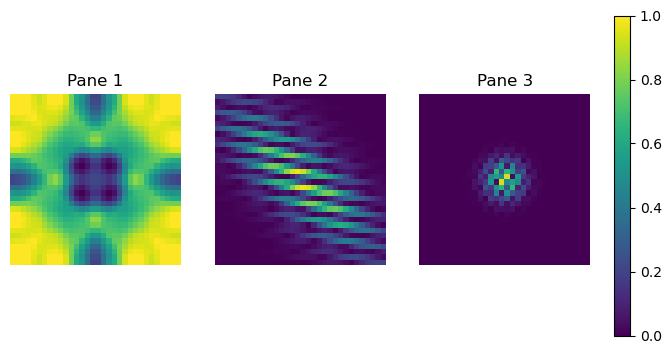

In [12]:
# Visualize a random sample input from the dataset
random_idx = np.random.randint(0, len(dataset))
random_input, random_output = dataset[random_idx]
input_shape = random_input.shape

fig, axes = plt.subplots(1, input_shape[0], figsize=(8, 8))
axes = axes.flatten()

# Create a list to store all images for finding shared colorbar range
images = []
for i in range(3):
    if i == 0:
        img = random_input[i].numpy()
    else:
        img = random_input[i].abs().numpy()
    images.append(img)

# Find global min/max for consistent colorbar
vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

# Plot images with shared colorbar
for i in range(3):
    im = axes[i].imshow(images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Pane {i+1}')
    axes[i].axis('off')

# Add colorbar with height matching images
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.02, 0.4])  # Reduced height from 0.6 to 0.4 and adjusted vertical position
fig.colorbar(im, cax=cbar_ax)

plt.show()

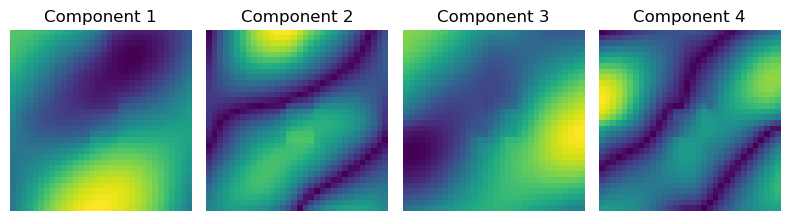

In [13]:
# Visualize a random sample output from the dataset
output_shape = random_output.shape

fig, axes = plt.subplots(1, output_shape[0], figsize=(8, 8))
axes = axes.flatten()

for i in range(4):
    if i % 2 == 0:
        img = random_output[i].numpy()
    else:
        img = random_output[i].abs().numpy()
    axes[i].imshow(img, cmap='viridis')
    axes[i].set_title(f'Component {i+1}')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [14]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels, out_channels, hidden, num_layers):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         n_modes_height=self.modes_height, 
                         n_modes_width=self.modes_width, 
                         hidden_channels=self.hidden, 
                         n_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [15]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100, save_after_batch=False, save_path=None):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    progress_bar = tqdm(enumerate(loader), total=total_batches, desc=f"Epoch {epoch + 1}")

    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # print(f"Model output shape: {outputs.shape}")
        # print(f"Target shape: {targets.shape}")
        # print(f"Number of channels in output: {outputs.shape[1]}")
        # print(f"Data type: {outputs.dtype}")
        # print(f"Range of values: [{outputs.min().item()}, {outputs.max().item()}]")
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            progress_bar.set_postfix(batch_loss=loss.item())

        # Save model weights after each batch if the flag is set
        if save_after_batch and save_path:
            save_model(model, save_path)

    epoch_loss = running_loss / len(loader.dataset)

    # Save model weights after each epoch if the flag is not set
    if not save_after_batch and save_path:
        save_model(model, save_path)

    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [16]:
def plot_sample(data, title, labels, shared_colorbar=False, vmin=None, vmax=None, layout=None, save=False, save_path='plot.png'):
    # Automatically select layout based on the number of data arrays if not provided
    num_arrays = data.shape[0]
    if layout is None:
        if num_arrays == 3:
            layout = (1, 3)
        elif num_arrays == 4:
            layout = (2, 2)
        else:
            raise ValueError("Data input must have 3 or 4 arrays for plotting.")

    # Adjust figure size based on layout
    if layout == (1, 3):
        fig, axes = plt.subplots(*layout, figsize=(12, 4))  # Wide and short for 1x3 layout
    elif layout == (2, 2):
        fig, axes = plt.subplots(*layout, figsize=(8, 8))   # Square for 2x2 layout
    else:
        raise ValueError("Unsupported layout")

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist())
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)

    if save:
        # Save the figure
        plt.savefig(save_path)
        print(f"Plot saved at {save_path}")
        plt.close(fig)
    else:
        # Display the figure
        plt.show()

def plot_inputs(data, title, labels, save=False, save_path='example_plot.png'):
    # Plot inputs with layout (1, 3) and custom figure size
    plot_sample(data, title, labels, shared_colorbar=True, layout=(1, 3), save=save, save_path=save_path)

def plot_predictions_and_targets(inputs, outputs, targets, save=False, save_dir='figures/', file_suffix='example'):
    # Ensure save directory exists if save is True
    if save:
        os.makedirs(save_dir, exist_ok=True)

    # Add file_suffix to the filenames
    input_filename = f'{save_dir}/input_{file_suffix}.png'
    output_filename = f'{save_dir}/output_{file_suffix}.png'
    target_filename = f'{save_dir}/target_{file_suffix}.png'

    input_labels = [(0, 'geometry'), (1, 'waveform'), (2, 'band')]
    plot_inputs(inputs, 'Inputs', input_labels, save=save, save_path=input_filename)

    # Compute global min and max for shared colorbar between outputs and targets
    vmin = min(np.min(outputs.cpu().numpy()), np.min(targets.cpu().numpy()))
    vmax = max(np.max(outputs.cpu().numpy()), np.max(targets.cpu().numpy()))

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=output_filename)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True, vmin=vmin, vmax=vmax, save=save, save_path=target_filename)


In [17]:
hc = 128; lr = 1e-3; wd = 1e-3; ss = 4; gamma = 0.1; design_res = 32

model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc, num_layers=4).to(device)
#model = model.half()

criterion = nn.MSELoss(reduction='mean') # Use mean squared error loss
#criterion = criterion.half()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ss, gamma=gamma)

In [18]:
print('Train data size:', len(train_dataset))
#print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

# Inspect the first batch of data
for sample in train_loader:
    print('Batch shape:', sample[0].shape, sample[1].shape)
    #print(sample)
    break

# Check model precision
def check_model_precision(model):
    print("Model Precision:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.dtype}")

check_model_precision(model)

# Check criterion precision
print(f"\nCriterion Precision: {criterion.dtype if hasattr(criterion, 'dtype') else 'N/A'}")

Train data size: 1866240
Validation data size: 466560
Batch shape: torch.Size([256, 3, 32, 32]) torch.Size([256, 4, 32, 32])
Model Precision:
fno.fno_blocks.convs.0.bias: torch.float32
fno.fno_blocks.convs.0.weight.tensor: torch.complex64
fno.fno_blocks.convs.1.bias: torch.float32
fno.fno_blocks.convs.1.weight.tensor: torch.complex64
fno.fno_blocks.convs.2.bias: torch.float32
fno.fno_blocks.convs.2.weight.tensor: torch.complex64
fno.fno_blocks.convs.3.bias: torch.float32
fno.fno_blocks.convs.3.weight.tensor: torch.complex64
fno.fno_blocks.fno_skips.0.conv.weight: torch.float32
fno.fno_blocks.fno_skips.1.conv.weight: torch.float32
fno.fno_blocks.fno_skips.2.conv.weight: torch.float32
fno.fno_blocks.fno_skips.3.conv.weight: torch.float32
fno.fno_blocks.channel_mlp.0.fcs.0.weight: torch.float32
fno.fno_blocks.channel_mlp.0.fcs.0.bias: torch.float32
fno.fno_blocks.channel_mlp.0.fcs.1.weight: torch.float32
fno.fno_blocks.channel_mlp.0.fcs.1.bias: torch.float32
fno.fno_blocks.channel_mlp.1.f

In [19]:
# Parameters for saving/loading model weights
save_path = f'./model_L2_random_subset_hc{hc}_lr{lr:.0e}_wd{wd:.0e}_ss{ss}_gamma{gamma:.0e}.pth'
print(save_path)
load_existing_model = False  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(save_path):
    load_model(model, save_path)
    print(f"Loaded model weights from {save_path}")

# Lists to store losses for plotting
train_losses = []
val_losses = []

./model_L2_random_subset_hc128_lr1e-03_wd1e-03_ss4_gamma1e-01.pth


Evaluating: 100%|██████████| 1823/1823 [02:08<00:00, 14.21it/s]
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/24, Training Loss: 0.0001789922, Validation Loss: 0.0001204861


Evaluating: 100%|██████████| 1823/1823 [02:06<00:00, 14.43it/s]


Epoch 2/24, Training Loss: 0.0001038656, Validation Loss: 0.0000924672


Evaluating: 100%|██████████| 1823/1823 [02:05<00:00, 14.49it/s]


Epoch 3/24, Training Loss: 0.0000844006, Validation Loss: 0.0000796864


Evaluating: 100%|██████████| 1823/1823 [02:06<00:00, 14.42it/s]


Epoch 4/24, Training Loss: 0.0000747737, Validation Loss: 0.0000728154


Evaluating: 100%|██████████| 1823/1823 [02:12<00:00, 13.78it/s]


Epoch 5/24, Training Loss: 0.0000685764, Validation Loss: 0.0000698393


Evaluating: 100%|██████████| 1823/1823 [02:10<00:00, 14.02it/s]


Epoch 6/24, Training Loss: 0.0000639099, Validation Loss: 0.0000678176


Evaluating: 100%|██████████| 1823/1823 [02:14<00:00, 13.58it/s]


Epoch 7/24, Training Loss: 0.0000600519, Validation Loss: 0.0000651651


Evaluating: 100%|██████████| 1823/1823 [02:10<00:00, 13.99it/s]


Epoch 8/24, Training Loss: 0.0000566342, Validation Loss: 0.0000641527


Evaluating: 100%|██████████| 1823/1823 [02:10<00:00, 13.98it/s]


Epoch 9/24, Training Loss: 0.0000535282, Validation Loss: 0.0000634239


Evaluating: 100%|██████████| 1823/1823 [02:14<00:00, 13.59it/s]


Epoch 10/24, Training Loss: 0.0000507949, Validation Loss: 0.0000639919


Evaluating: 100%|██████████| 1823/1823 [02:10<00:00, 13.96it/s]


Epoch 11/24, Training Loss: 0.0000482518, Validation Loss: 0.0000633280


Evaluating: 100%|██████████| 1823/1823 [02:15<00:00, 13.44it/s]


Epoch 12/24, Training Loss: 0.0000458987, Validation Loss: 0.0000633916


Evaluating: 100%|██████████| 1823/1823 [02:06<00:00, 14.41it/s]


Epoch 13/24, Training Loss: 0.0000436553, Validation Loss: 0.0000636097


Evaluating: 100%|██████████| 1823/1823 [02:07<00:00, 14.29it/s]


Epoch 14/24, Training Loss: 0.0000415395, Validation Loss: 0.0000640620


Evaluating: 100%|██████████| 1823/1823 [02:07<00:00, 14.31it/s]


Epoch 15/24, Training Loss: 0.0000394056, Validation Loss: 0.0000646854


Evaluating: 100%|██████████| 1823/1823 [02:14<00:00, 13.54it/s]


Epoch 16/24, Training Loss: 0.0000374166, Validation Loss: 0.0000649236


Evaluating: 100%|██████████| 1823/1823 [02:09<00:00, 14.10it/s]


Epoch 17/24, Training Loss: 0.0000354970, Validation Loss: 0.0000655063


Evaluating: 100%|██████████| 1823/1823 [02:14<00:00, 13.51it/s]


Epoch 18/24, Training Loss: 0.0000334532, Validation Loss: 0.0000667572


Evaluating: 100%|██████████| 1823/1823 [02:12<00:00, 13.72it/s]


Epoch 19/24, Training Loss: 0.0000314558, Validation Loss: 0.0000666584


Evaluating: 100%|██████████| 1823/1823 [02:12<00:00, 13.76it/s]


Epoch 20/24, Training Loss: 0.0000294809, Validation Loss: 0.0000672649


Evaluating: 100%|██████████| 1823/1823 [02:09<00:00, 14.04it/s]


Epoch 21/24, Training Loss: 0.0000276722, Validation Loss: 0.0000671633


Evaluating: 100%|██████████| 1823/1823 [02:10<00:00, 13.98it/s]


Epoch 22/24, Training Loss: 0.0000258479, Validation Loss: 0.0000681921


Evaluating: 100%|██████████| 1823/1823 [02:25<00:00, 12.52it/s]


Epoch 23/24, Training Loss: 0.0000240870, Validation Loss: 0.0000696066


Evaluating: 100%|██████████| 1823/1823 [02:06<00:00, 14.45it/s]


Epoch 24/24, Training Loss: 0.0000223425, Validation Loss: 0.0000692762


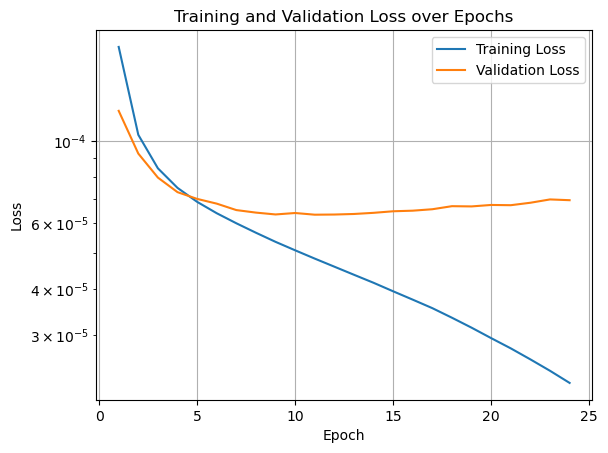

In [20]:
# Training loop
num_epochs = 24
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=256, save_after_batch=False, save_path=save_path)
    
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

timestamp = datetime.now().strftime('%y%m%d-%H%M%S')
# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set the y-axis to log scale
plt.savefig(f'loss_plot_L2_{timestamp}.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [21]:
# Save the model weights at the end of training
# save_model(model, save_path)sdasdasdas
save_path_posttraining = f'{save_path[:-4]}_e{len(train_losses)}.pth'
save_model(model, save_path_posttraining)
print(f"Saved model weights to {save_path_posttraining}")

Saved model weights to ./model_L2_random_subset_hc128_lr1e-03_wd1e-03_ss4_gamma1e-01_e24.pth


Sample loss: 0.000002


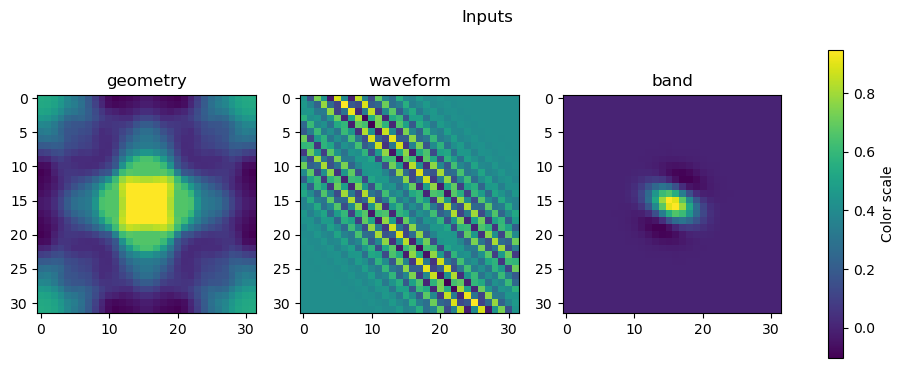

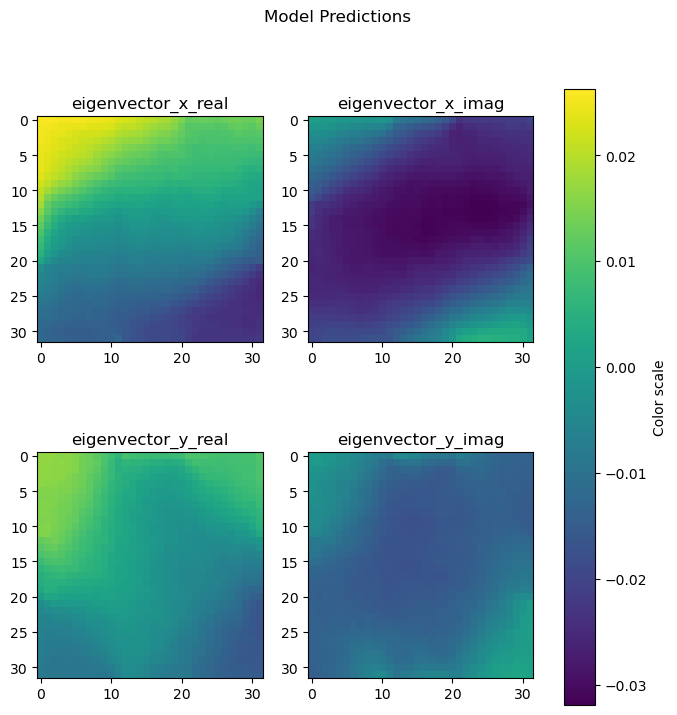

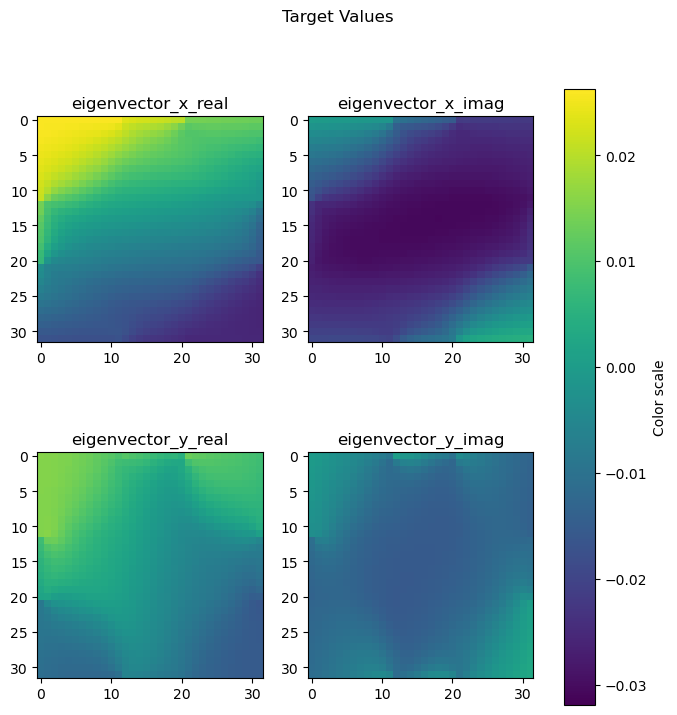

In [22]:
# Get a batch from the validation loader
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a single sample from the batch
input_sample = inputs[42]
target_sample = targets[42]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)
    sample_loss = criterion(output_sample.unsqueeze(0), target_sample.unsqueeze(0))
    print(f"Sample loss: {sample_loss.item():.6f}")

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)


Sample loss: 0.000026


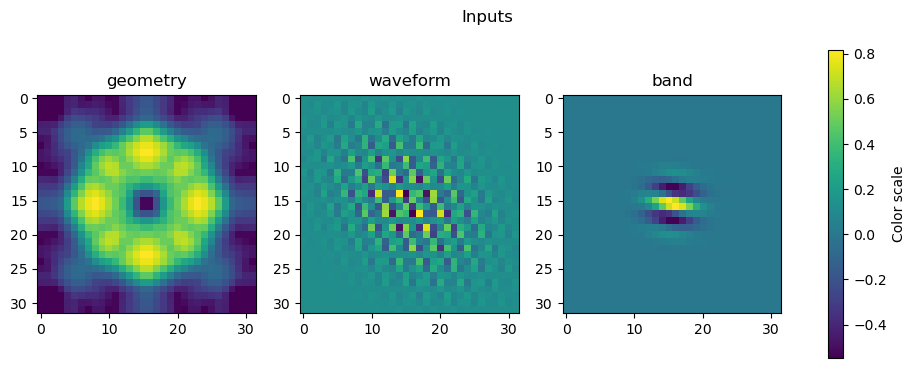

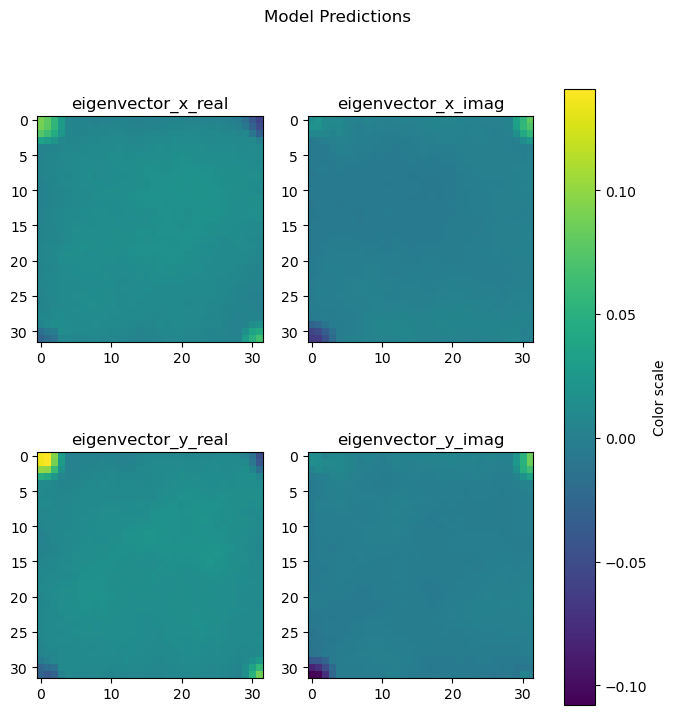

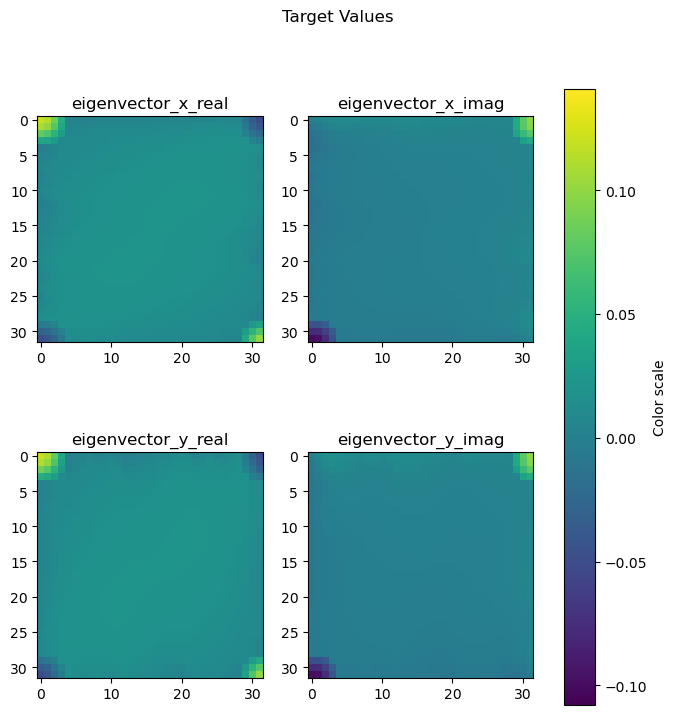

In [23]:
# Get a batch from the train loader
inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a random sample from the batch
random_idx = torch.randint(0, len(inputs), (1,)).item()
input_sample = inputs[random_idx]
target_sample = targets[random_idx]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)
    sample_loss = criterion(output_sample.unsqueeze(0), target_sample.unsqueeze(0))
    print(f"Sample loss: {sample_loss.item():.6f}")

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)

In [24]:
def plot_model_weights_histogram(model, log_scale=False, print_analytics=False):
    """
    Plots a histogram of the weight values of a given model.
    
    Parameters:
        model: The model object (e.g., PyTorch or TensorFlow model).
        log_scale (bool): If True, the y-axis of the histogram is set to logarithmic scale.
        print_analytics (bool): If True, prints the mean, standard deviation, and total number of weights.
    """
    # Extract all weight values
    weights = []

    # For PyTorch model
    if hasattr(model, "parameters"):
        for param in model.parameters():
            if param.requires_grad:  # Focus only on trainable parameters
                weights.append(param.data.cpu().numpy().flatten())

    # For TensorFlow/Keras model
    elif hasattr(model, "trainable_weights"):
        for layer_weights in model.trainable_weights:
            weights.append(layer_weights.numpy().flatten())

    else:
        raise ValueError("Unsupported model type. The model must be a PyTorch or TensorFlow model.")

    # Flatten and concatenate all weights into a single array
    all_weights = np.concatenate(weights)

    # Print analytics if the flag is set
    if print_analytics:
        mean = np.mean(all_weights)
        std_dev = np.std(all_weights)
        total_weights = all_weights.size
        print(f"Model Weight Analytics:")
        print(f"  Mean: {mean:.4f}")
        print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Total Number of Weights: {total_weights}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title("Histogram of Model Weight Values")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

    if log_scale:
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.ylabel("Frequency (log scale)")

    plt.grid(axis='y', alpha=0.75)
    plt.show()

Model Weight Analytics:
  Mean: -0.0001+0.0000j
  Standard Deviation: 0.1236
  Total Number of Weights: 35852932


c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\numpy\lib\histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\axes\_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


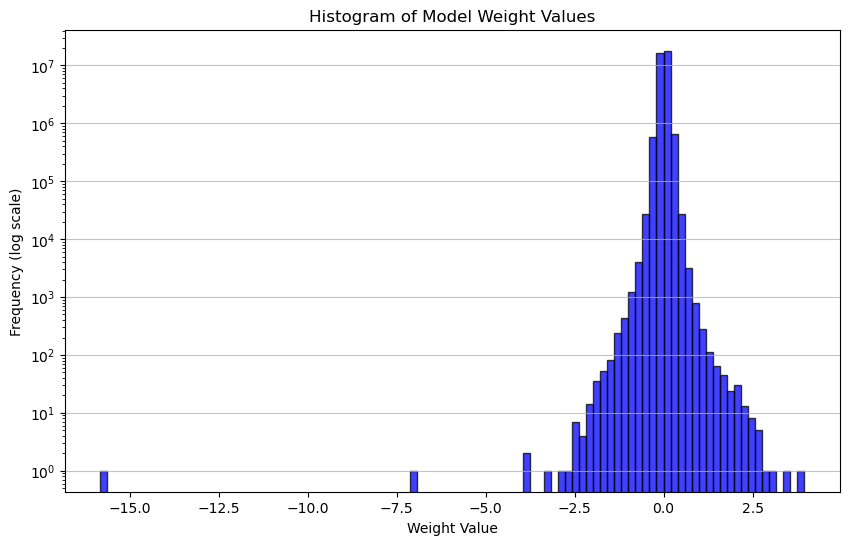

In [25]:
plot_model_weights_histogram(model, log_scale=True, print_analytics=True)

In [26]:
initialized_model = FourierNeuralOperator(modes_height=design_res, 
                                          modes_width=design_res, 
                                          in_channels=3, 
                                          out_channels=4, 
                                          hidden=hc,
                                          num_layers=4).to(device)

Model Weight Analytics:
  Mean: 0.0000-0.0000j
  Standard Deviation: 0.0883
  Total Number of Weights: 35852932


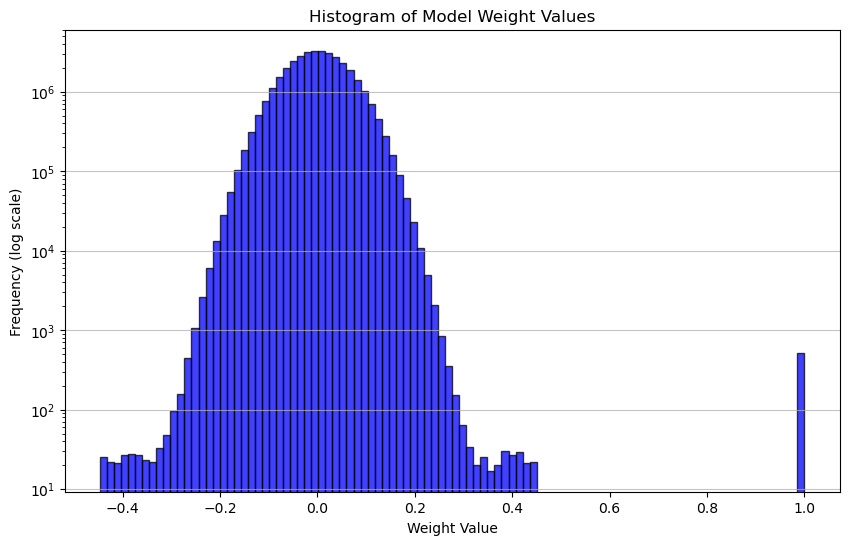

In [27]:
plot_model_weights_histogram(initialized_model, log_scale=True, print_analytics=True)

## Calculate losses on test dataset using average absolute error to give a training loss agnostic representation of performance

In [28]:
# Set model to evaluation mode
model.eval()

# Initialize running statistics
running_error_sum = 0
running_error_sq_sum = 0
running_l1_loss = 0
running_count = 0
min_pixel = float('inf')
max_pixel = float('-inf')
pixel_sum = 0

with torch.no_grad():
    for data, target in tqdm(val_loader, desc="Evaluating"):
        # Move data to device if using GPU
        data, target = data.to(device), target.to(device)
        
        # Get model predictions
        output = model(data)
        
        # Calculate absolute percentage error for each pixel
        abs_perc_error = torch.abs((output - target) / (target + 1e-8)) * 100
        
        # Calculate batch statistics
        batch_error = torch.mean(abs_perc_error, dim=(1,2,3))  # Average over all dimensions except batch
        
        # Update running statistics on GPU
        running_error_sum += torch.sum(batch_error)
        running_error_sq_sum += torch.sum(batch_error ** 2)
        running_l1_loss += torch.nn.functional.l1_loss(output, target) * target.size(0)
        running_count += target.size(0)  # Count number of samples, not pixels
        
        # Update pixel statistics on GPU
        min_pixel = min(min_pixel, target.min().item())
        max_pixel = max(max_pixel, target.max().item()) 
        pixel_sum += target.sum().item()

# Calculate final statistics
mean_error = (running_error_sum / running_count).cpu().item()
std_error = torch.sqrt(running_error_sq_sum/running_count - (running_error_sum/running_count)**2).cpu().item()
mean_l1_loss = (running_l1_loss / len(val_loader.dataset)).cpu().item()
mean_pixel = pixel_sum / (running_count * target.size(1) * target.size(2) * target.size(3))

print(f"Test Set Statistics:")
#print(f"Average Sample Percentage Error: {mean_error:.2f}% ± {std_error:.2f}%")
print(f"Average L1 Loss: {mean_l1_loss:.6f}")
print(f"\nDataset Pixel Value Statistics:")
print(f"Min: {min_pixel:.6f}")
print(f"Mean: {mean_pixel:.6f}")
print(f"Max: {max_pixel:.6f}")

Evaluating: 100%|██████████| 1823/1823 [02:07<00:00, 14.34it/s]


Test Set Statistics:
Average L1 Loss: 0.003653

Dataset Pixel Value Statistics:
Min: -0.675293
Mean: -0.000135
Max: 0.642090
